**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions.

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [1]:
#Install Objax
!pip --quiet install  objax
import objax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 2.5 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random
import matplotlib.pyplot as plt

##**Part 1. Building a CNN**

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [100]:
#.load_data() by default returns a split between training and test set.
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()    # (batch_size, height, width, channels)
X_train = X_train.transpose(0, 3, 1, 2) / 255.0                                 # (batch_size, channels, height, width)
Y_train = Y_train.flatten()                                                     # from [[1] [9] ... [3]] to [1 9 ... 3]
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]


Next we will construct a **Base Model**, which in our case is a small CNN.

In [101]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns.



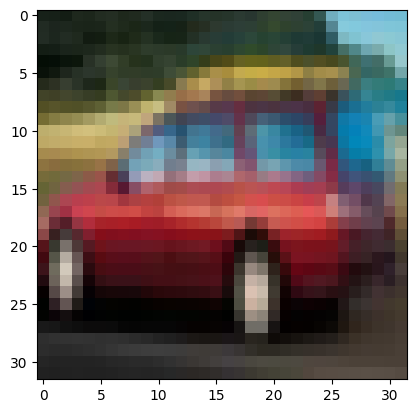

In [ ]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output.

In [5]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

print("Filter weights:", filter_weights)
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape(Conv2d(my_image)))

Filter weights: [[[[ 0.7304995   0.6803058 ]
   [-1.0113425  -0.19040492]
   [-0.3848219   0.6740011 ]]]]
Conv output: [[[[-0.10271908 -0.10010862 -0.09076816 ... -0.7420423  -0.73912483
    -0.7374622 ]
   [-0.12882358 -0.11180528 -0.11687267 ... -0.73105437 -0.7434611
    -0.7408506 ]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.6991137  -0.7174033
    -0.7156083 ]
   ...
   [-0.11485983 -0.10963893 -0.10963893 ... -0.11178758 -0.11439803
    -0.12222939]
   [-0.09658667 -0.09136578 -0.09136578 ... -0.1274503  -0.12483985
    -0.12483985]
   [-0.08614487 -0.08353443 -0.08614487 ... -0.16399662 -0.16138618
    -0.15355481]]

  [[ 0.10279882  0.0982345   0.08189839 ...  0.75253254  0.7320599
     0.7214626 ]
   [ 0.14844204  0.1263671   0.1275416  ...  0.77934486  0.7626404
     0.7580761 ]
   [ 0.15300636  0.12562042  0.15036322 ...  0.79253834  0.77845234
     0.775332  ]
   ...
   [ 0.20083015  0.1917015   0.1917015  ...  0.27218536  0.27674967
     0.29044265]
   [ 0.1688799   0.

**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [6]:
#Solution to the above problem

def my_conv_net(my_image, initial_filter_weights):
  my_conv_output = np.zeros((1, 2, 32, 32))
  for input_channel in range(len(initial_filter_weights[0][0])):
    for output_channel in range(len(initial_filter_weights[0][0][0])):
      for height in range(len(my_image[0][0])):
        for width in range(len(my_image[0][0][0])):
          my_conv_output[0][output_channel][height][width] += initial_filter_weights[0][0][input_channel][output_channel] * my_image[0][input_channel][height][width]
  return my_conv_output

my_conv_output = my_conv_net(my_image,filter_weights)
print("Conv output:", Conv2d(my_image))
print("my Conv output:", my_conv_output)

# The difference is around 10e-8, which is small enough to be ignored

Conv output: [[[[-0.10271908 -0.10010862 -0.09076816 ... -0.7420423  -0.73912483
    -0.7374622 ]
   [-0.12882358 -0.11180528 -0.11687267 ... -0.73105437 -0.7434611
    -0.7408506 ]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.6991137  -0.7174033
    -0.7156083 ]
   ...
   [-0.11485983 -0.10963893 -0.10963893 ... -0.11178758 -0.11439803
    -0.12222939]
   [-0.09658667 -0.09136578 -0.09136578 ... -0.1274503  -0.12483985
    -0.12483985]
   [-0.08614487 -0.08353443 -0.08614487 ... -0.16399662 -0.16138618
    -0.15355481]]

  [[ 0.10279882  0.0982345   0.08189839 ...  0.75253254  0.7320599
     0.7214626 ]
   [ 0.14844204  0.1263671   0.1275416  ...  0.77934486  0.7626404
     0.7580761 ]
   [ 0.15300636  0.12562042  0.15036322 ...  0.79253834  0.77845234
     0.775332  ]
   ...
   [ 0.20083015  0.1917015   0.1917015  ...  0.27218536  0.27674967
     0.29044265]
   [ 0.1688799   0.15975127  0.15975127 ...  0.29957128  0.29500696
     0.29500696]
   [ 0.15062262  0.14605829  0.15062262 

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer.

In [ ]:
#Check that .mean((2,3)) rearranges your image
my_conv_output.mean((2,3))

#alternative ways: mean pooling / max pooling

array([[-0.1400071 ,  0.35388903]])

Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.**



In [7]:
#PUT YOUR CODE HERE
# Objax's linear layer.
Objax_Linear_Layer = objax.nn.Linear(2, 1)
Objax_linear_output = Objax_Linear_Layer(my_conv_output.mean((2,3)))
w_linear = Objax_Linear_Layer.w.value
b_linear = Objax_Linear_Layer.b.value
print("Objax's Linear output:", Objax_linear_output)

# my linear layer
my_linear_output = np.array([[my_conv_output.mean((2,3))[0][0]*w_linear[0][0] + my_conv_output.mean((2,3))[0][1]*w_linear[1][0] + b_linear[0]]])
print("my linear output:",my_linear_output)

Objax's Linear output: [[0.03471544]]
my linear output: [[0.03471544]]


You have now completed Part 1 of the assignment. Good job!


# Question 1

The split: training 48000, validation 6000, test 6000.

Number of iterations to go through entire training set: 48000/32 = 1500

Number of iterations in 30 epochs: 30 * 1500 = 45000

# Question 4

The training set is the portion of the dataset used to train the model.
During the training phase, the model learns from the data points in the training set by adjusting weights and bias to minimize the loss function. The validation set is another potion of the dataset that is not seen by the model during training. Models with different values of hyperparameters are trained by the training set and validation set is used to compute the accuracy of these models. The model with the highest accuracy will be selected for testing on the rest of the dataset (test set).

##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

In [174]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value -= grad * lr
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [175]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.31 Validation Loss 2.29 Training Accuracy 13.56 Validation Accuracy 13.58
Epoch 0002  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 14.19 Validation Accuracy 15.63
Epoch 0003  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 15.15 Validation Accuracy 17.02
Epoch 0004  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 16.44 Validation Accuracy 16.50
Epoch 0005  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 17.44 Validation Accuracy 17.60
Epoch 0006  Training Loss 2.26 Validation Loss 2.26 Training Accuracy 18.11 Validation Accuracy 19.23
Epoch 0007  Training Loss 2.25 Validation Loss 2.25 Training Accuracy 19.55 Validation Accuracy 18.90
Epoch 0008  Training Loss 2.24 Validation Loss 2.24 Training Accuracy 19.37 Validation Accuracy 19.63
Epoch 0009  Training Loss 2.23 Validation Loss 2.23 Training Accuracy 19.88 Validation Accuracy 20.27
Epoch 0010  Training Loss 2.22 Validation Loss 2.21 Training Accuracy 19.95 Valida

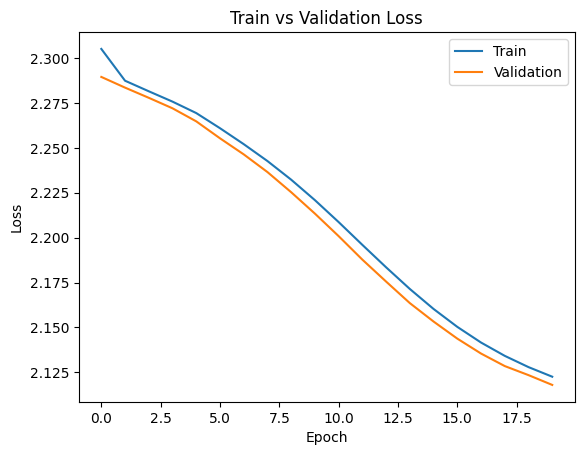

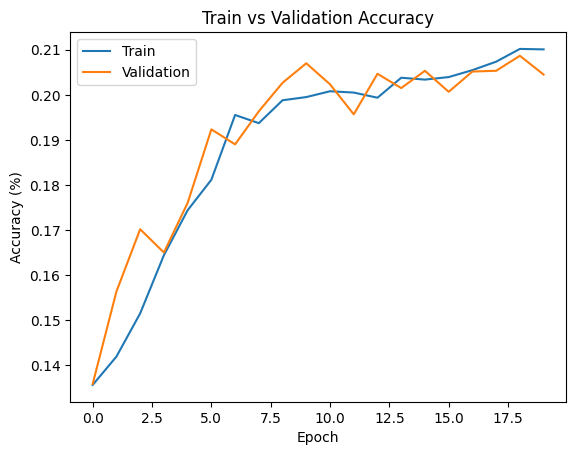

In [104]:
train()
base_model = model

Follow the assignment handout for questions to be answered in this part of the assignment.

# Question 4

A hyperparameter is a parameter whose value cannot be tuned during the training process, and thus its value has to be set before the training process begins.

It's crucial not to evaluate the accuracy on the test set until all hyperparameters have been tuned because the model can only see the test set once at the testing phase to maintain accuracy on evaluating the model upon unseen data. If the test set is used for iterative tuning or decision-making during hyperparameter adjustments, information from the test set leaks into the model's learning process, compromising its ability to generalize to new, unseen data. To maintain the test set's integrity, hyperparameter tuning and model adjustments should be based on the separate validation set, ensuring the final evaluation on the test set remains unbiased and reliable.








In [ ]:
# Question 5
# hyperparameters selected H = {batch size, learning rate, number of outputs of conv layer 1, number of conv layers}
H_1 = {64, 0.001, 20, 2}
H_2 = {16, 0.01, 32, 3}

In [105]:
# Question 6, H_1 = {64, 0.001, 20, 2}

# CNN 1
class M_1(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 20, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(20, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = M_1()

Epoch 0001  Training Loss 2.33 Validation Loss 2.30 Training Accuracy 9.93 Validation Accuracy 10.18
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 9.68 Validation Accuracy 9.83
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 9.78 Validation Accuracy 10.07
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.36 Validation Accuracy 10.78
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.71 Validation Accuracy 11.73
Epoch 0006  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 11.41 Validation Accuracy 12.42
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 12.08 Validation Accuracy 12.67
Epoch 0008  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 12.46 Validation Accuracy 12.97
Epoch 0009  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 12.72 Validation Accuracy 13.60
Epoch 0010  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 13.24 Validation

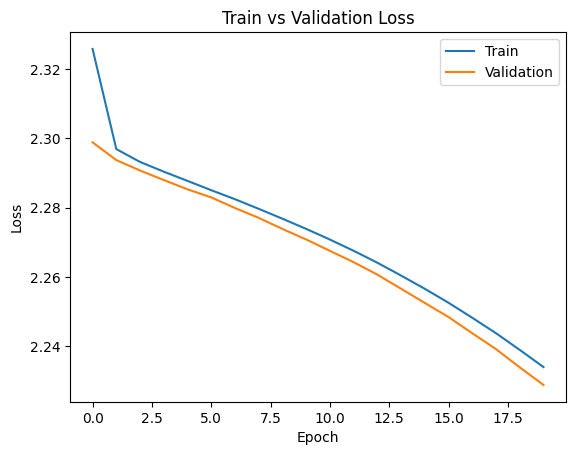

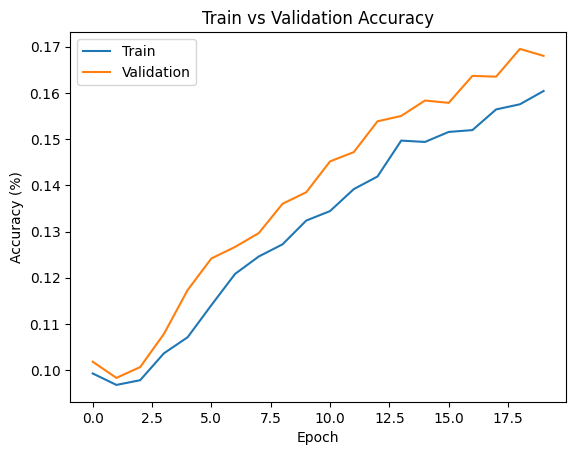

In [108]:
train(BATCH=64,LEARNING_RATE=0.001)
model_M1 = model

In [112]:
# CNN 2 H_2 = {16, 0.01, 32, 3}
class M_2(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 16, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(16, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
    x = self.conv_3(x)
    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = M_2()

Epoch 0001  Training Loss 2.18 Validation Loss 2.04 Training Accuracy 20.64 Validation Accuracy 26.17
Epoch 0002  Training Loss 1.98 Validation Loss 1.91 Training Accuracy 30.96 Validation Accuracy 28.52
Epoch 0003  Training Loss 1.88 Validation Loss 1.86 Training Accuracy 35.12 Validation Accuracy 31.90
Epoch 0004  Training Loss 1.81 Validation Loss 1.81 Training Accuracy 38.30 Validation Accuracy 32.45
Epoch 0005  Training Loss 1.74 Validation Loss 1.70 Training Accuracy 41.32 Validation Accuracy 35.58
Epoch 0006  Training Loss 1.69 Validation Loss 1.68 Training Accuracy 42.97 Validation Accuracy 35.83
Epoch 0007  Training Loss 1.65 Validation Loss 1.61 Training Accuracy 44.50 Validation Accuracy 40.27
Epoch 0008  Training Loss 1.62 Validation Loss 1.57 Training Accuracy 45.64 Validation Accuracy 41.50
Epoch 0009  Training Loss 1.59 Validation Loss 1.59 Training Accuracy 46.58 Validation Accuracy 40.27
Epoch 0010  Training Loss 1.56 Validation Loss 1.54 Training Accuracy 47.72 Valida

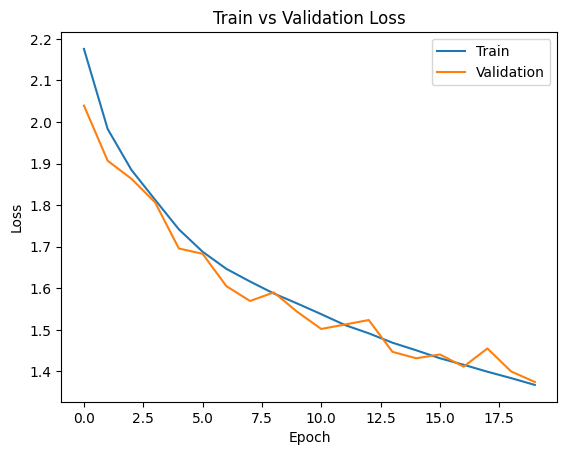

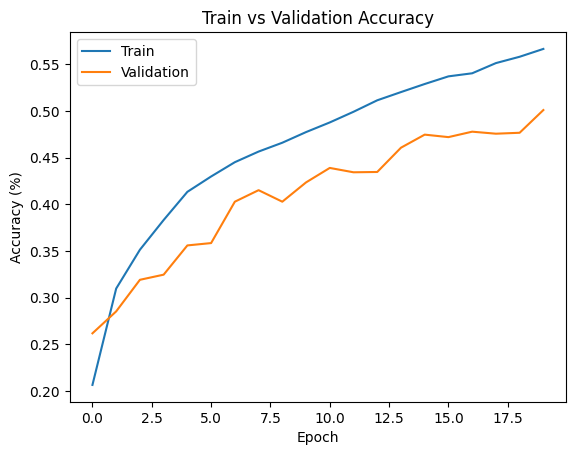

In [115]:
train(BATCH=16,LEARNING_RATE=0.01)
model_M2 = model

Best Validation Accuracy:

Base model: 20.70% at epoch 10

M1: 16.95% at epoch 19

M2: 50.08% at epoch 20

M2 performs the best in terms of validation accuracy.

In [116]:
# Question 7
# M2 is picked as final model to evaluate on test set, because M2 has the best validation accuracy.
model = model_M2
test_prediction = predict(X_test).argmax(1)
test_accuracy = (np.array(test_prediction).flatten() == Y_test).sum()
test_accuracy = test_accuracy / X_test.shape[0]
print("Test accuracy is:",test_accuracy*100,"%")

Test accuracy is: 49.88333333333333 %


You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**

See the handout for instructions.


In [117]:
# Question 1
# data set chosen: cifar100
# from https://www.tensorflow.org/datasets/catalog/cifar100

#.load_data() by default returns a split between training and test set.
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar100.load_data()   # (batch_size, height, width, channels)
X_train = X_train.transpose(0, 3, 1, 2) / 255.0                                 # (batch_size, channels, height, width)
Y_train = Y_train.flatten()                                                     # from [[1] [9] ... [3]] to [1 9 ... 3]
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

In [118]:
# Question 2, create a base model
class Base_model(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 16, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(16, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
    x = self.conv_3(x)
    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = Base_model()
#You can examine the architecture of our CNN by calling model.vars()

Epoch 0001  Training Loss 4.61 Validation Loss 4.60 Training Accuracy 1.10 Validation Accuracy 1.07
Epoch 0002  Training Loss 4.60 Validation Loss 4.60 Training Accuracy 1.27 Validation Accuracy 1.43
Epoch 0003  Training Loss 4.60 Validation Loss 4.60 Training Accuracy 1.48 Validation Accuracy 1.45
Epoch 0004  Training Loss 4.60 Validation Loss 4.60 Training Accuracy 1.63 Validation Accuracy 1.35
Epoch 0005  Training Loss 4.59 Validation Loss 4.59 Training Accuracy 1.61 Validation Accuracy 1.80
Epoch 0006  Training Loss 4.57 Validation Loss 4.56 Training Accuracy 2.19 Validation Accuracy 2.08
Epoch 0007  Training Loss 4.52 Validation Loss 4.47 Training Accuracy 2.21 Validation Accuracy 1.87
Epoch 0008  Training Loss 4.43 Validation Loss 4.38 Training Accuracy 2.72 Validation Accuracy 2.55
Epoch 0009  Training Loss 4.36 Validation Loss 4.36 Training Accuracy 3.70 Validation Accuracy 3.60
Epoch 0010  Training Loss 4.33 Validation Loss 4.31 Training Accuracy 4.65 Validation Accuracy 3.83


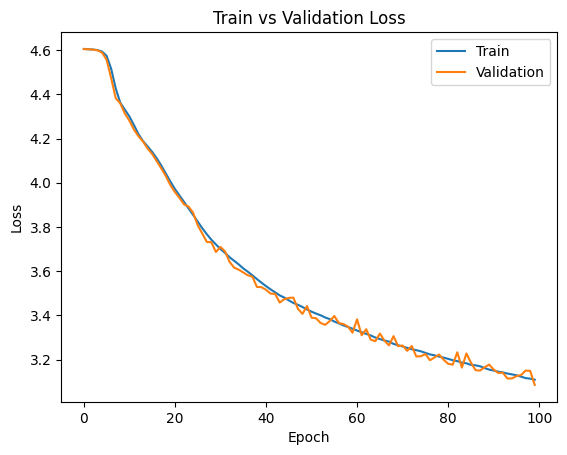

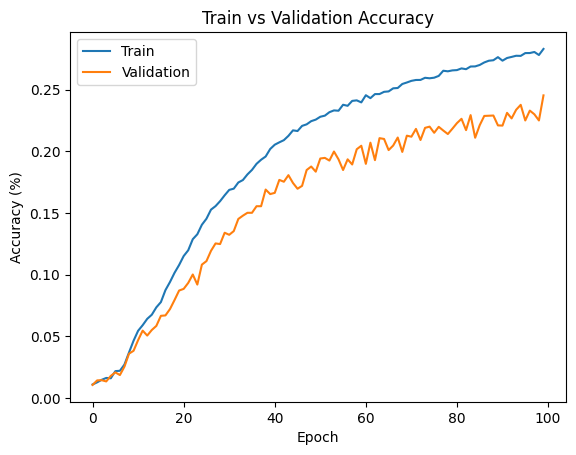

In [121]:
train(EPOCHS=100,BATCH=32,LEARNING_RATE=0.01)
base_model = model
# the best validation accuracy for the base model is 24.53% at epoch 100

In [122]:
# question 3, tune hyperparameters
# tune number of feature maps in each convolution convolution layer:
# Base model: {number of feature maps in layer 1,2,3} = {32, 32, 16}
# M1：        {number of feature maps in layer 1,2,3} = {32, 64, 32}
# M2：        {number of feature maps in layer 1,2,3} = {32, 64, 96}
# M3：        {number of feature maps in layer 1,2,3} = {64, 64, 64}
class M_1(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 64, 2), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(64, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
    x = self.conv_3(x)
    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = M_1()
#You can examine the architecture of our CNN by calling model.vars()

Epoch 0001  Training Loss 4.60 Validation Loss 4.60 Training Accuracy 1.36 Validation Accuracy 1.87
Epoch 0002  Training Loss 4.59 Validation Loss 4.58 Training Accuracy 2.07 Validation Accuracy 2.30
Epoch 0003  Training Loss 4.56 Validation Loss 4.52 Training Accuracy 2.03 Validation Accuracy 2.35
Epoch 0004  Training Loss 4.47 Validation Loss 4.42 Training Accuracy 2.67 Validation Accuracy 2.80
Epoch 0005  Training Loss 4.38 Validation Loss 4.35 Training Accuracy 3.59 Validation Accuracy 3.12
Epoch 0006  Training Loss 4.34 Validation Loss 4.33 Training Accuracy 4.49 Validation Accuracy 3.80
Epoch 0007  Training Loss 4.32 Validation Loss 4.30 Training Accuracy 5.02 Validation Accuracy 3.73
Epoch 0008  Training Loss 4.29 Validation Loss 4.27 Training Accuracy 5.46 Validation Accuracy 4.13
Epoch 0009  Training Loss 4.25 Validation Loss 4.22 Training Accuracy 6.04 Validation Accuracy 5.53
Epoch 0010  Training Loss 4.20 Validation Loss 4.18 Training Accuracy 7.00 Validation Accuracy 6.07


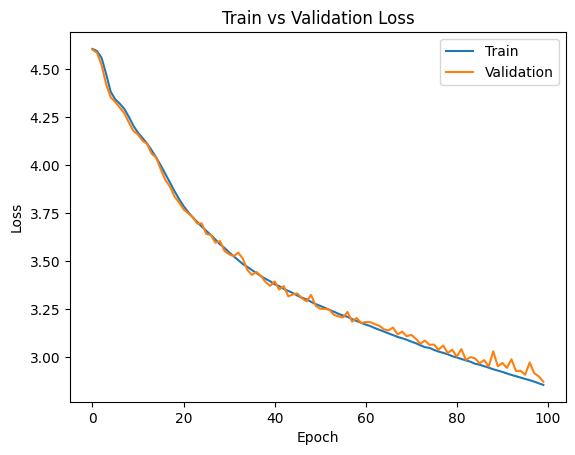

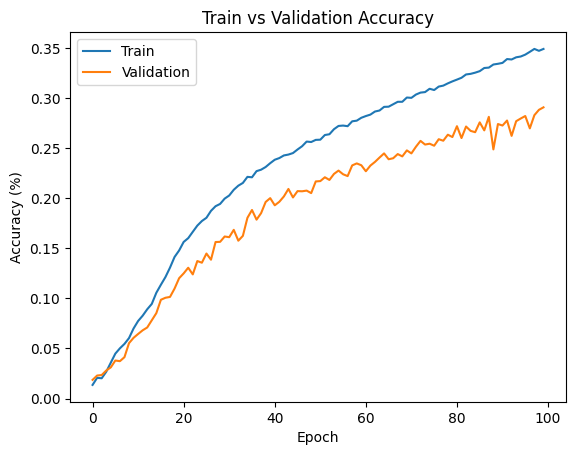

In [125]:
train(EPOCHS=100,BATCH=32,LEARNING_RATE=0.01)
model_m1 = model
# the best validation accuracy for M1 is 29.08% at epoch 100

In [126]:
# M2：        {number of feature maps in layer 1,2,3} = {32, 64, 96}
class M_2(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 64, 2), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(64, 96, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(96, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
    x = self.conv_3(x)
    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = M_2()
#You can examine the architecture of our CNN by calling model.vars()

Epoch 0001  Training Loss 4.60 Validation Loss 4.59 Training Accuracy 1.51 Validation Accuracy 1.52
Epoch 0002  Training Loss 4.58 Validation Loss 4.56 Training Accuracy 1.70 Validation Accuracy 1.63
Epoch 0003  Training Loss 4.51 Validation Loss 4.44 Training Accuracy 2.11 Validation Accuracy 2.23
Epoch 0004  Training Loss 4.39 Validation Loss 4.36 Training Accuracy 3.96 Validation Accuracy 3.10
Epoch 0005  Training Loss 4.34 Validation Loss 4.32 Training Accuracy 5.12 Validation Accuracy 3.67
Epoch 0006  Training Loss 4.30 Validation Loss 4.27 Training Accuracy 5.99 Validation Accuracy 4.33
Epoch 0007  Training Loss 4.25 Validation Loss 4.22 Training Accuracy 6.90 Validation Accuracy 5.42
Epoch 0008  Training Loss 4.20 Validation Loss 4.17 Training Accuracy 7.72 Validation Accuracy 6.35
Epoch 0009  Training Loss 4.16 Validation Loss 4.13 Training Accuracy 8.67 Validation Accuracy 6.78
Epoch 0010  Training Loss 4.12 Validation Loss 4.11 Training Accuracy 9.32 Validation Accuracy 7.22


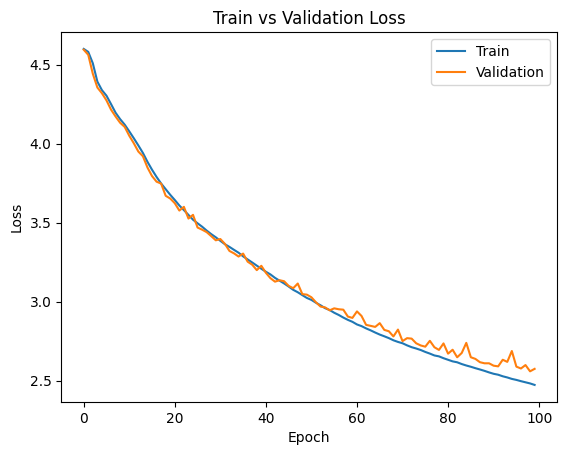

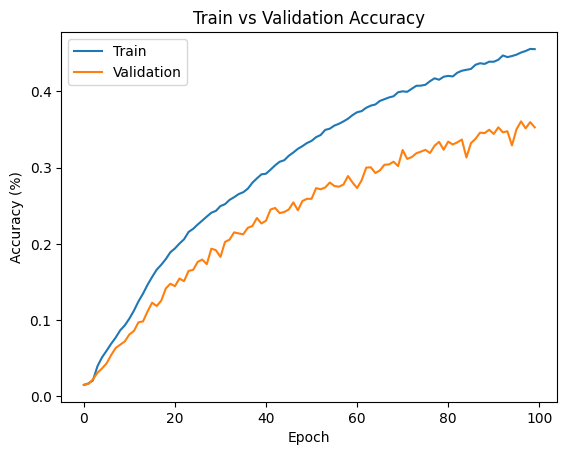

In [129]:
train(EPOCHS=100,BATCH=32,LEARNING_RATE=0.01)
model_m2 = model
# the best validation accuracy for M2 is 36.05% at epoch 97

In [130]:
# M3：        {number of feature maps in layer 1,2,3} = {64, 64, 64}
class M_3(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 64, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(64, 64, 2), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(64, 64, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(64, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
    x = self.conv_3(x)
    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = M_3()
#You can examine the architecture of our CNN by calling model.vars()

Epoch 0001  Training Loss 4.60 Validation Loss 4.59 Training Accuracy 1.45 Validation Accuracy 1.30
Epoch 0002  Training Loss 4.57 Validation Loss 4.53 Training Accuracy 2.20 Validation Accuracy 2.37
Epoch 0003  Training Loss 4.45 Validation Loss 4.38 Training Accuracy 3.18 Validation Accuracy 3.05
Epoch 0004  Training Loss 4.36 Validation Loss 4.33 Training Accuracy 4.40 Validation Accuracy 3.27
Epoch 0005  Training Loss 4.32 Validation Loss 4.29 Training Accuracy 5.32 Validation Accuracy 3.80
Epoch 0006  Training Loss 4.27 Validation Loss 4.24 Training Accuracy 6.56 Validation Accuracy 5.27
Epoch 0007  Training Loss 4.21 Validation Loss 4.17 Training Accuracy 7.85 Validation Accuracy 6.55
Epoch 0008  Training Loss 4.15 Validation Loss 4.13 Training Accuracy 8.81 Validation Accuracy 6.55
Epoch 0009  Training Loss 4.11 Validation Loss 4.08 Training Accuracy 9.74 Validation Accuracy 7.30
Epoch 0010  Training Loss 4.06 Validation Loss 4.03 Training Accuracy 10.73 Validation Accuracy 8.55

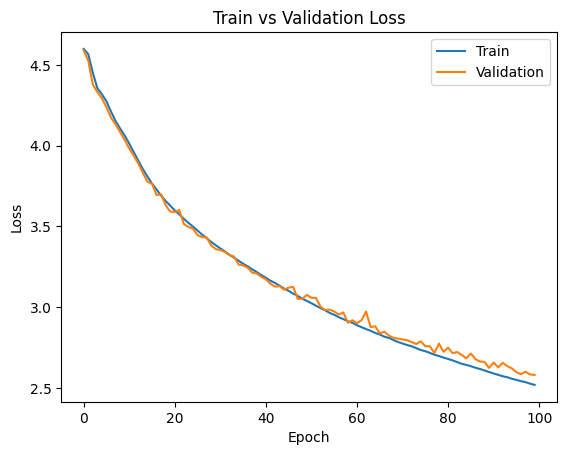

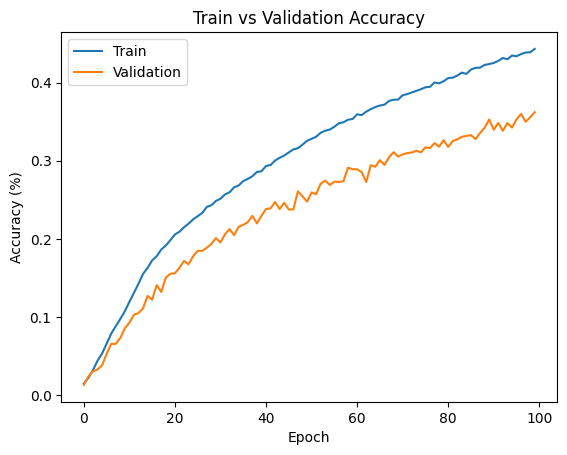

In [133]:
train(EPOCHS=100,BATCH=32,LEARNING_RATE=0.01)
model_m3 = model
# the best validation accuracy for M3 is 36.22% at epoch 100

In [ ]:
# In conclusion,
# number of feature maps in each convolution convolution layer:
# Base model: {number of feature maps in layer 1,2,3} = {32, 32, 16}
# M1：        {number of feature maps in layer 1,2,3} = {32, 64, 32}
# M2：        {number of feature maps in layer 1,2,3} = {32, 64, 96}
# M3：        {number of feature maps in layer 1,2,3} = {64, 64, 64}

# the best validation accuracy for the base model is 24.53% at epoch 100
# the best validation accuracy for M1 is 29.08% at epoch 100
# the best validation accuracy for M2 is 36.05% at epoch 97
# the best validation accuracy for M3 is 36.22% at epoch 100

In [144]:
# Question 4
# M3 is picked as final model to evaluate on test set, because M3 has the best validation accuracy.
model = model_m3
test_prediction = predict(X_test).argmax(1)
test_accuracy = (np.array(test_prediction).flatten() == Y_test).sum()
test_accuracy = test_accuracy / X_test.shape[0]
print("Test accuracy is:",test_accuracy*100,"%")

Test accuracy is: 33.71666666666667 %


##**Problem 4. Open-Ended Exploration**

See the handout for instructions.

# Question 1

##What was the question?

Question1: Additional hyperparameter tuning

##Which hyperparameters did you tune?

I will tune filter size k.

The full expression of classobjax.nn.Conv2D is

classobjax.nn.Conv2D(nin, nout, k, strides=1, dilations=1, groups=1, padding=ConvPadding.SAME, use_bias=True, w_init='<'function kaiming_normal'>')

nin is the number of input channels.

nout is the number of output channels.

k is the size of the filter.

strides is the step size taken by the filter during convolution, i.e. k = 1 stride = 1 means no stride. (while scanning inputs: moving from (0,0) to (1,0)). stide = 2 means moving two pixels per time (moving from (0,0) to (2,0))

dialations: "skip some value from the input". ie. dialation = 2, k = 2. For the first point (0,0) on the output channel, I need to convolve the filter with points (0,0), (2,0), (0,2), (2,2) on the input channel.

Padding: define the padding strategy. zero-padding: if k = 2, the output size will be smaller than the input size by 1, filter only go through spaces completely inside the input channel. Same Padding: Padding is added to the input so that the output size remains the same as the input size, the input size and the output size are the same.For a 2D convolution, if the filter size is k x k and the stride is 1, the number of pixels added around the input image is (k - 1) / 2 on each side

use_bias: Use bias or not.

w_init: Weight initialize method.

#How many models did you try and what are their performances in terms of validation accuracy?

I use the best model M3 from part 3 as the base model. (k = 2)

And train CNNs with different filter sizes. The result are summarized in the table below.

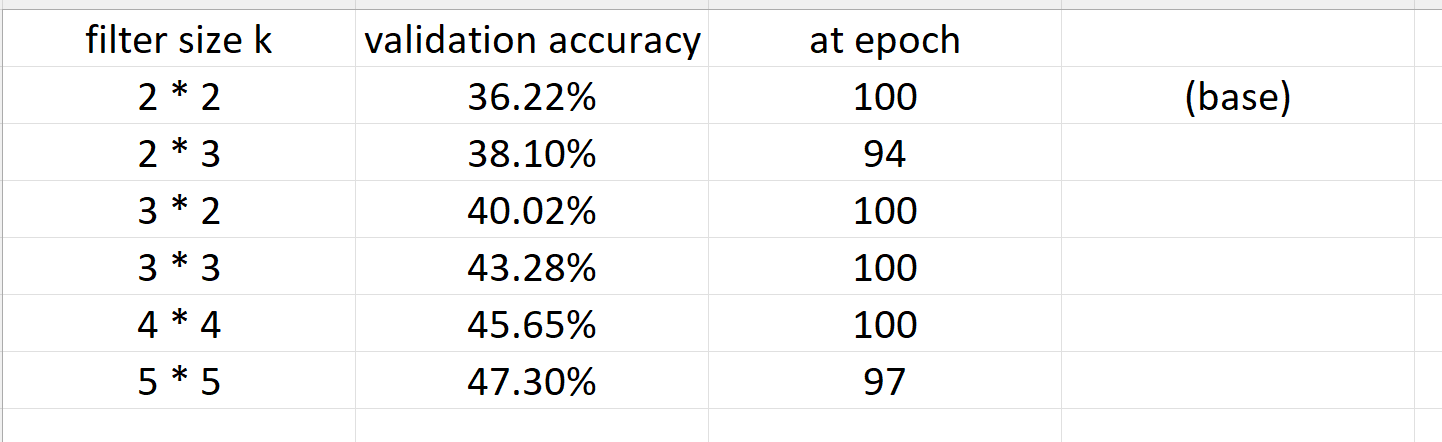


#How did you choose your final model?

The model with filter size 5*5 is chosen as it achieves the highest validation accuracy


In [152]:
# A sample code snapshot
# select the base model to be the best model from part 3
class M_31(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 64, (2,3)), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(64, 64, (2,3)), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(64, 64, (2,3)), objax.functional.relu])
    self.linear = objax.nn.Linear(64, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
    x = self.conv_3(x)
    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = M_31()

Epoch 0001  Training Loss 4.60 Validation Loss 4.59 Training Accuracy 1.33 Validation Accuracy 1.92
Epoch 0002  Training Loss 4.57 Validation Loss 4.52 Training Accuracy 2.13 Validation Accuracy 2.07
Epoch 0003  Training Loss 4.43 Validation Loss 4.36 Training Accuracy 3.24 Validation Accuracy 3.25
Epoch 0004  Training Loss 4.34 Validation Loss 4.31 Training Accuracy 5.03 Validation Accuracy 3.67
Epoch 0005  Training Loss 4.29 Validation Loss 4.26 Training Accuracy 6.20 Validation Accuracy 5.03
Epoch 0006  Training Loss 4.22 Validation Loss 4.17 Training Accuracy 7.43 Validation Accuracy 5.97
Epoch 0007  Training Loss 4.15 Validation Loss 4.11 Training Accuracy 8.67 Validation Accuracy 7.23
Epoch 0008  Training Loss 4.09 Validation Loss 4.08 Training Accuracy 9.95 Validation Accuracy 7.65
Epoch 0009  Training Loss 4.04 Validation Loss 4.07 Training Accuracy 11.19 Validation Accuracy 8.15
Epoch 0010  Training Loss 3.99 Validation Loss 3.97 Training Accuracy 12.25 Validation Accuracy 9.7

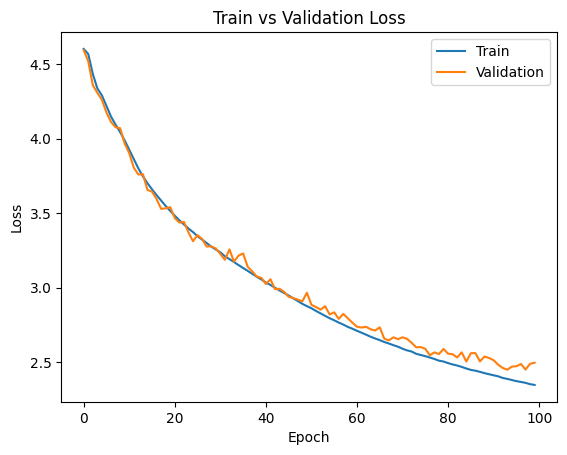

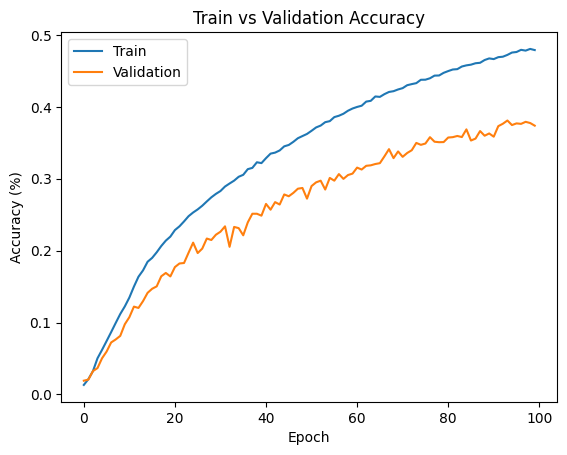

In [155]:
train(EPOCHS=100,BATCH=32,LEARNING_RATE=0.01)
model_m31 = model

In [156]:
class M_32(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 64, (3,2)), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(64, 64, (3,2)), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(64, 64, (3,2)), objax.functional.relu])
    self.linear = objax.nn.Linear(64, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
    x = self.conv_3(x)
    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = M_32()

Epoch 0001  Training Loss 4.60 Validation Loss 4.59 Training Accuracy 1.72 Validation Accuracy 2.23
Epoch 0002  Training Loss 4.56 Validation Loss 4.50 Training Accuracy 2.32 Validation Accuracy 2.63
Epoch 0003  Training Loss 4.42 Validation Loss 4.35 Training Accuracy 3.38 Validation Accuracy 3.05
Epoch 0004  Training Loss 4.33 Validation Loss 4.29 Training Accuracy 4.99 Validation Accuracy 3.55
Epoch 0005  Training Loss 4.29 Validation Loss 4.25 Training Accuracy 6.04 Validation Accuracy 4.32
Epoch 0006  Training Loss 4.22 Validation Loss 4.17 Training Accuracy 7.42 Validation Accuracy 5.68
Epoch 0007  Training Loss 4.13 Validation Loss 4.11 Training Accuracy 9.10 Validation Accuracy 6.73
Epoch 0008  Training Loss 4.05 Validation Loss 4.03 Training Accuracy 10.81 Validation Accuracy 7.45
Epoch 0009  Training Loss 3.99 Validation Loss 3.95 Training Accuracy 12.24 Validation Accuracy 8.87
Epoch 0010  Training Loss 3.92 Validation Loss 3.91 Training Accuracy 13.68 Validation Accuracy 10

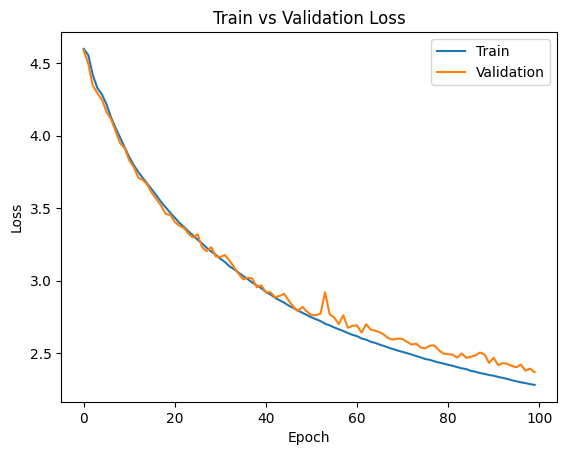

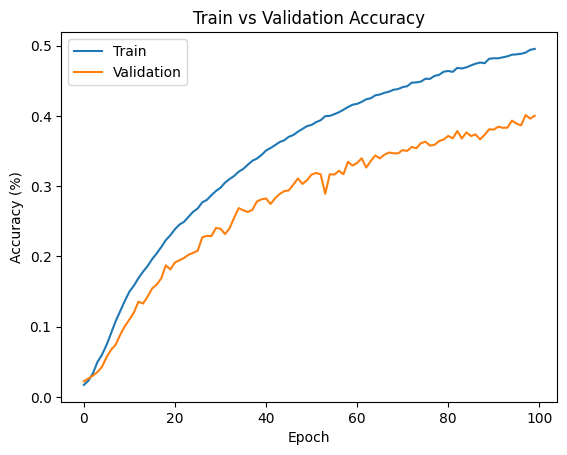

In [159]:
train(EPOCHS=100,BATCH=32,LEARNING_RATE=0.01)
model_m32 = model

In [160]:
class M_33(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 64, 3), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(64, 64, 3), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(64, 64, 3), objax.functional.relu])
    self.linear = objax.nn.Linear(64, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
    x = self.conv_3(x)
    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = M_33()

Epoch 0001  Training Loss 4.59 Validation Loss 4.57 Training Accuracy 1.66 Validation Accuracy 2.40
Epoch 0002  Training Loss 4.48 Validation Loss 4.37 Training Accuracy 2.98 Validation Accuracy 3.43
Epoch 0003  Training Loss 4.33 Validation Loss 4.27 Training Accuracy 5.65 Validation Accuracy 4.43
Epoch 0004  Training Loss 4.23 Validation Loss 4.17 Training Accuracy 7.80 Validation Accuracy 6.10
Epoch 0005  Training Loss 4.12 Validation Loss 4.09 Training Accuracy 9.73 Validation Accuracy 6.90
Epoch 0006  Training Loss 4.03 Validation Loss 3.98 Training Accuracy 11.27 Validation Accuracy 9.17
Epoch 0007  Training Loss 3.96 Validation Loss 3.95 Training Accuracy 12.44 Validation Accuracy 8.42
Epoch 0008  Training Loss 3.89 Validation Loss 3.86 Training Accuracy 13.99 Validation Accuracy 10.00
Epoch 0009  Training Loss 3.83 Validation Loss 3.86 Training Accuracy 14.82 Validation Accuracy 10.00
Epoch 0010  Training Loss 3.78 Validation Loss 3.73 Training Accuracy 16.09 Validation Accurac

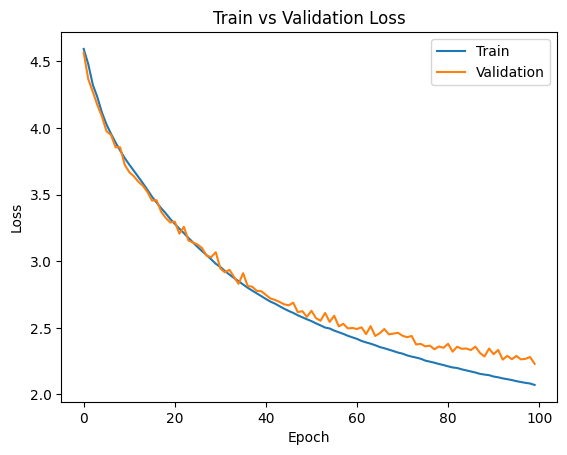

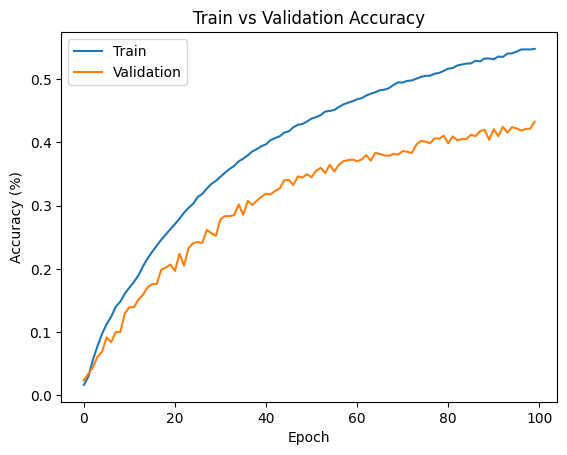

In [163]:
train(EPOCHS=100,BATCH=32,LEARNING_RATE=0.01)
model_m33 = model

In [164]:
class M_34(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 64, 4), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(64, 64, 4), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(64, 64, 4), objax.functional.relu])
    self.linear = objax.nn.Linear(64, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
    x = self.conv_3(x)
    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = M_34()

Epoch 0001  Training Loss 4.58 Validation Loss 4.50 Training Accuracy 2.11 Validation Accuracy 2.20
Epoch 0002  Training Loss 4.40 Validation Loss 4.31 Training Accuracy 4.43 Validation Accuracy 3.48
Epoch 0003  Training Loss 4.28 Validation Loss 4.24 Training Accuracy 6.91 Validation Accuracy 4.78
Epoch 0004  Training Loss 4.16 Validation Loss 4.09 Training Accuracy 9.39 Validation Accuracy 6.48
Epoch 0005  Training Loss 4.04 Validation Loss 3.97 Training Accuracy 11.64 Validation Accuracy 8.47
Epoch 0006  Training Loss 3.94 Validation Loss 3.89 Training Accuracy 13.70 Validation Accuracy 10.20
Epoch 0007  Training Loss 3.86 Validation Loss 3.80 Training Accuracy 15.41 Validation Accuracy 11.30
Epoch 0008  Training Loss 3.79 Validation Loss 3.74 Training Accuracy 17.02 Validation Accuracy 12.78
Epoch 0009  Training Loss 3.71 Validation Loss 3.68 Training Accuracy 18.24 Validation Accuracy 13.53
Epoch 0010  Training Loss 3.64 Validation Loss 3.60 Training Accuracy 20.11 Validation Accu

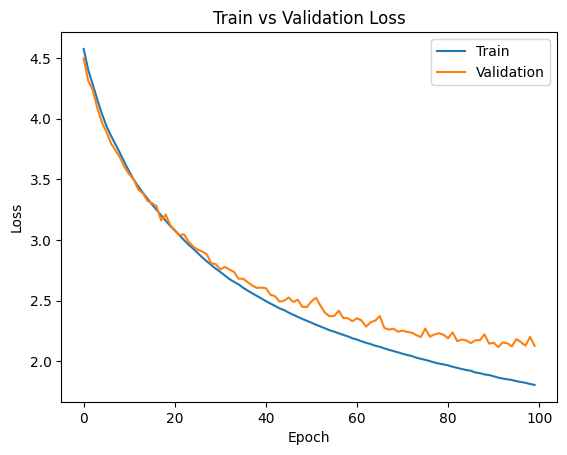

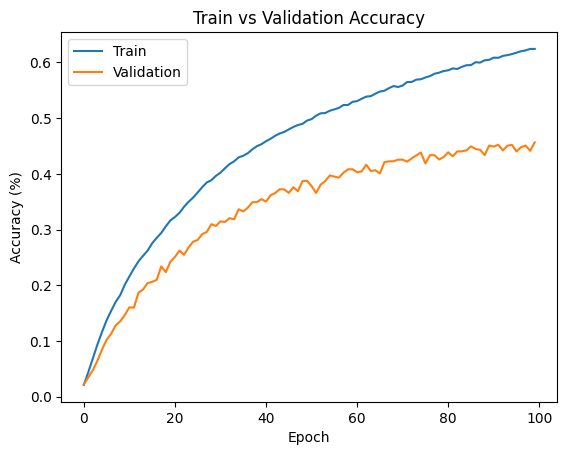

In [167]:
train(EPOCHS=100,BATCH=32,LEARNING_RATE=0.01)
model_m34 = model

In [168]:
class M_35(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 64, 5), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(64, 64, 5), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(64, 64, 5), objax.functional.relu])
    self.linear = objax.nn.Linear(64, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
    x = self.conv_3(x)
    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = M_35()

Epoch 0001  Training Loss 4.59 Validation Loss 4.53 Training Accuracy 2.08 Validation Accuracy 2.22
Epoch 0002  Training Loss 4.39 Validation Loss 4.29 Training Accuracy 4.73 Validation Accuracy 4.00
Epoch 0003  Training Loss 4.19 Validation Loss 4.08 Training Accuracy 9.46 Validation Accuracy 7.47
Epoch 0004  Training Loss 4.01 Validation Loss 3.92 Training Accuracy 13.11 Validation Accuracy 9.82
Epoch 0005  Training Loss 3.89 Validation Loss 3.83 Training Accuracy 15.06 Validation Accuracy 10.83
Epoch 0006  Training Loss 3.81 Validation Loss 3.79 Training Accuracy 16.36 Validation Accuracy 12.60
Epoch 0007  Training Loss 3.73 Validation Loss 3.72 Training Accuracy 18.00 Validation Accuracy 13.03
Epoch 0008  Training Loss 3.65 Validation Loss 3.59 Training Accuracy 19.45 Validation Accuracy 15.22
Epoch 0009  Training Loss 3.57 Validation Loss 3.51 Training Accuracy 21.51 Validation Accuracy 16.75
Epoch 0010  Training Loss 3.49 Validation Loss 3.51 Training Accuracy 23.40 Validation Ac

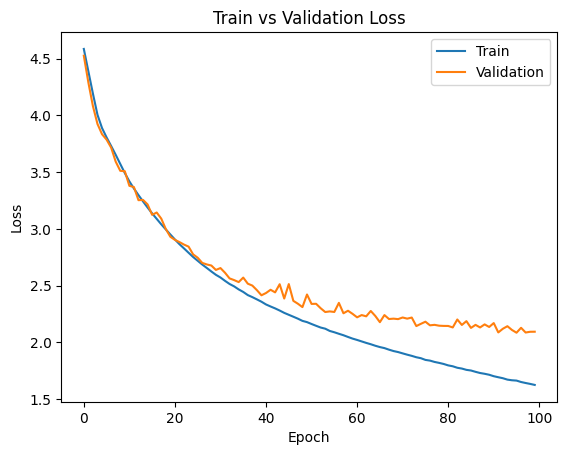

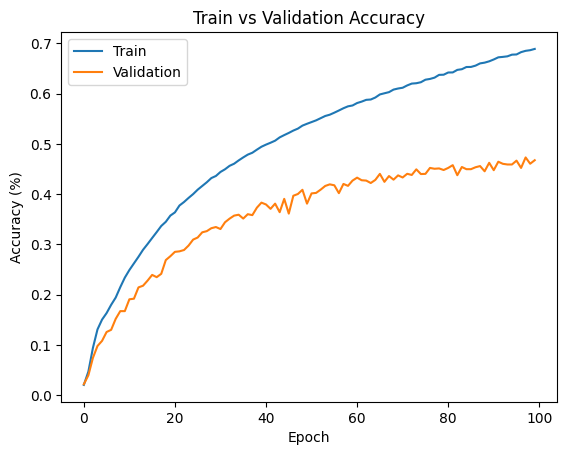

In [171]:
train(EPOCHS=100,BATCH=32,LEARNING_RATE=0.01)
model_m35 = model

In [172]:
# M35 is picked as final model to evaluate on test set, because M35 has the best validation accuracy.
model = model_m35
test_prediction = predict(X_test).argmax(1)
test_accuracy = (np.array(test_prediction).flatten() == Y_test).sum()
test_accuracy = test_accuracy / X_test.shape[0]
print("Test accuracy is:",test_accuracy*100,"%")

# There is an improvement of the test accuracy from 33.72% (base model) to 44.13%. One possible reason is that
# increasing the size of the filter allows the model to capture more complex patterns and features from the input data.

Test accuracy is: 44.13333333333333 %
